# 0. Import packages

In [1]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as pltfrom
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
import xgboost as xg

# 1. Load Base Datasets

In [4]:
INPUT_DIR='/kaggle/input/kaist-ie343-2023-spring'

In [5]:
## Do not change this cell. 
## The reason for this is to prevent cheating using the original data from DACON. 
## If an assertion error occurs in that cell when TAs evaluate the submitted code of each student, it is considered cheating.

train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
park = pd.read_csv(os.path.join(INPUT_DIR, 'park.csv'))
dcc = pd.read_csv(os.path.join(INPUT_DIR, 'day_care_center.csv'))

assert train.shape[0] == 329690 and train.shape[1] == 13, 'Do not change the format of the input data.'
assert test.shape[0] == 85097 and test.shape[1] == 12, 'Do not change the format of the input data.'
assert park.shape[0] == 1359 and park.shape[1] == 7, 'Do not change the format of the input data.'
assert dcc.shape[0] == 7373 and dcc.shape[1] == 10, 'Do not change the format of the input data.'

In [7]:
print(train.shape, test.shape, park.shape, dcc.shape)

(329690, 13) (85097, 12) (1359, 7) (7373, 10)


# 2. Load additional dataset
- You can use any additional data source, **excluding the original dataset from [DACON](https://dacon.io/competitions/open/21265/data)**

In [8]:
train.describe()

,index,apartment_id,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,PRICE
count,329690.000000,329690.000000,329690.000000,329690.000000,329690.000000,329690.000000,329601.000000,329601.000000,329690.000000,329690.000000,3.296900e+05
mean,164844.500000,2200.879177,113.374546,93.811417,1998.201474,9.649725,36.511732,127.899152,2020.380928,6.546344,4.236468e+05
std,95173.449462,1301.361025,67.664274,35.312279,9.099311,6.893568,1.180404,1.026130,1.308745,3.313855,3.276236e+05
min,0.000000,0.000000,0.000000,14.399720,1962.000000,-4.000000,35.058236,126.793126,2018.000000,1.000000,8.501200e+03
25%,82422.250000,1057.000000,56.000000,71.436483,1992.000000,4.000000,35.183442,127.012403,2019.000000,4.000000,2.185348e+05
50%,164844.500000,2188.000000,109.000000,99.697726,1999.000000,8.000000,37.486824,127.115032,2021.000000,7.000000,3.385540e+05
75%,247266.750000,3347.000000,171.000000,101.625662,2005.000000,13.000000,37.543500,129.065366,2021.000000,9.000000,5.185828e+05
max,329689.000000,4419.000000,236.000000,325.105962,2016.000000,70.000000,37.667270,129.202169,2022.000000,12.000000,7.073560e+06


*Combining park dataset with train dataset using dong.*

In [9]:
#to reduce dimensionality, park types with low counts will be collectively recorded as "etc"
park.loc[park["park_type"] == "culture park", "park_type"] = "etc"
park.loc[park["park_type"] == "historic park", "park_type"] = "etc"
park.loc[park["park_type"] == "agricultural park", "park_type"] = "etc"
park.loc[park["park_type"] == "sports park", "park_type"] = "etc"
park.loc[park["park_type"] == "cemetery park", "park_type"] = "etc"
park.loc[park["park_type"] == "waterside park", "park_type"] = "etc"
park.describe()

,gu,dong,park_area,park_open_year
count,1359.000000,1359.000000,1359.000000,937.000000
mean,15.953642,112.149375,104.042110,1990.151547
std,10.658927,67.431843,219.255942,17.656216
min,0.000000,0.000000,4.690416,1938.000000
25%,5.000000,57.000000,32.407417,1977.000000
50%,17.000000,106.000000,40.987803,1992.000000
75%,24.000000,170.500000,81.299446,2006.000000
max,35.000000,236.000000,2587.043680,2018.000000


In [10]:
train_seoul = train[train["city"]=="seoul"].drop(["city"], axis=1)
train_busan = train[train["city"]=="busan"].drop(["city"], axis=1)
park_seoul = park[park["city"]=="seoul"].drop(["city", "park_name"], axis=1)
park_busan = park[park["city"]=="busan"].drop(["city", "park_name"], axis=1)

In [11]:
park_stats = park_seoul.groupby(['dong', 'park_type']).agg({
    'park_type': 'count',
    'park_area': 'mean',
}).rename(columns={
    'park_type': 'park_count',
    'park_area': 'avg_area',
}).reset_index()

park_stats_pivot = park_stats.pivot(index='dong', columns='park_type')
park_stats_pivot.columns = ['{}_{}'.format(col[0], col[1]) for col in park_stats_pivot.columns]
df_combined = pd.merge(train_seoul, park_stats_pivot, left_on='dong', right_index=True, how='left')
df_combined.fillna(0, inplace=True)

temp_seoul = pd.merge(df_combined, park_seoul[["gu", "dong"]].drop_duplicates(), on='dong', how='left')

In [12]:
park_stats = park_busan.groupby(['dong', 'park_type']).agg({
    'park_type': 'count',
    'park_area': 'mean',
}).rename(columns={
    'park_type': 'park_count',
    'park_area': 'avg_area',
}).reset_index()

park_stats_pivot = park_stats.pivot(index='dong', columns='park_type')
park_stats_pivot.columns = ['{}_{}'.format(col[0], col[1]) for col in park_stats_pivot.columns]
df_combined = pd.merge(train_busan, park_stats_pivot, left_on='dong', right_index=True, how='left')
df_combined.fillna(0, inplace=True)

temp_busan = pd.merge(df_combined, park_busan[["gu", "dong"]].drop_duplicates(), on='dong', how='left')

Combining dcc and train

In [13]:
#handling inconsistent entries and creating a dummy variable, null is assumed to be 0
dcc.loc[dcc["is_commuting_vehicle"] == "N", "is_commuting_vehicle"] = 0
dcc.loc[dcc["is_commuting_vehicle"] == "n", "is_commuting_vehicle"] = 0
dcc.loc[dcc["is_commuting_vehicle"] == "Y", "is_commuting_vehicle"] = 1
dcc.loc[dcc["is_commuting_vehicle"] == "y", "is_commuting_vehicle"] = 1
dcc.loc[dcc["is_commuting_vehicle"] == ' ', "is_commuting_vehicle"] = 0

dcc.loc[dcc["day_care_type"] == "corporate", "day_care_type"] = "etc"
dcc.loc[dcc["day_care_type"] == "social welfare organization", "day_care_type"] = "etc"
dcc.loc[dcc["day_care_type"] == "workplace", "day_care_type"] = "etc"
dcc.loc[dcc["day_care_type"] == "cooperation", "day_care_type"] = "etc"

In [14]:
dcc_seoul = dcc[dcc["city"]=="seoul"].drop(["city", "day_care_name"], axis=1)
dcc_busan = dcc[dcc["city"]=="busan"].drop(["city", "day_care_name"], axis=1)

Combining dcc and train data based on gu (from park)

In [15]:
dcc_stats = dcc_seoul.groupby(['gu', 'day_care_type']).agg({
    'day_care_type': 'count',
    'day_care_baby_num': 'mean',
    'teacher_num': 'mean',
    'nursing_room_num': 'mean',
    'playground_num': 'mean',
    'CCTV_num': 'mean',
    'is_commuting_vehicle': 'mean',
    
}).rename(columns={
    'day_care_type': 'count',
    'day_care_baby_num': 'avg_babies',
    'teacher_num': 'avg_teachers',
    'nursing_room_num': 'avg_nursingrooms',
    'playground_num': 'avg_playgrounds',
    'CCTV_num': 'avg_cctv',
    'is_commuting_vehicle': 'avg_vehicles',
}).reset_index()

# Pivot the park statistics dataframe to have park types as columns
dcc_stats_pivot = dcc_stats.pivot(index='gu', columns='day_care_type')

# Flatten the column names for the pivoted dataframe
dcc_stats_pivot.columns = ['{}_{}'.format(col[0], col[1]) for col in dcc_stats_pivot.columns]

# Merge the neighbourhood dataframe with the park statistics
combined_seoul = pd.merge(temp_seoul, dcc_stats_pivot, left_on='gu', right_index=True, how='left')

# Fill missing values with 0 for neighbourhoods with no parks of a particular type
combined_seoul.fillna(0, inplace=True)

In [16]:
dcc_stats = dcc_busan.groupby(['gu', 'day_care_type']).agg({
    'day_care_type': 'count',
    'day_care_baby_num': 'mean',
    'teacher_num': 'mean',
    'nursing_room_num': 'mean',
    'playground_num': 'mean',
    'CCTV_num': 'mean',
    'is_commuting_vehicle': 'mean',
    
}).rename(columns={
    'day_care_type': 'count',
    'day_care_baby_num': 'avg_babies',
    'teacher_num': 'avg_teachers',
    'nursing_room_num': 'avg_nursingrooms',
    'playground_num': 'avg_playgrounds',
    'CCTV_num': 'avg_cctv',
    'is_commuting_vehicle': 'avg_vehicles',
}).reset_index()

# Pivot the park statistics dataframe to have park types as columns
dcc_stats_pivot = dcc_stats.pivot(index='gu', columns='day_care_type')

# Flatten the column names for the pivoted dataframe
dcc_stats_pivot.columns = ['{}_{}'.format(col[0], col[1]) for col in dcc_stats_pivot.columns]

# Merge the neighbourhood dataframe with the park statistics
combined_busan = pd.merge(temp_busan, dcc_stats_pivot, left_on='gu', right_index=True, how='left')

# Fill missing values with 0 for neighbourhoods with no parks of a particular type
combined_busan.fillna(0, inplace=True)

**Removing duplicates**

In [17]:
#inherent low-quality entries in datasets
combined_seoul = combined_seoul.drop_duplicates(subset='index')
combined_busan = combined_busan.drop_duplicates(subset='index')

# 3. EDA and Preprocessing

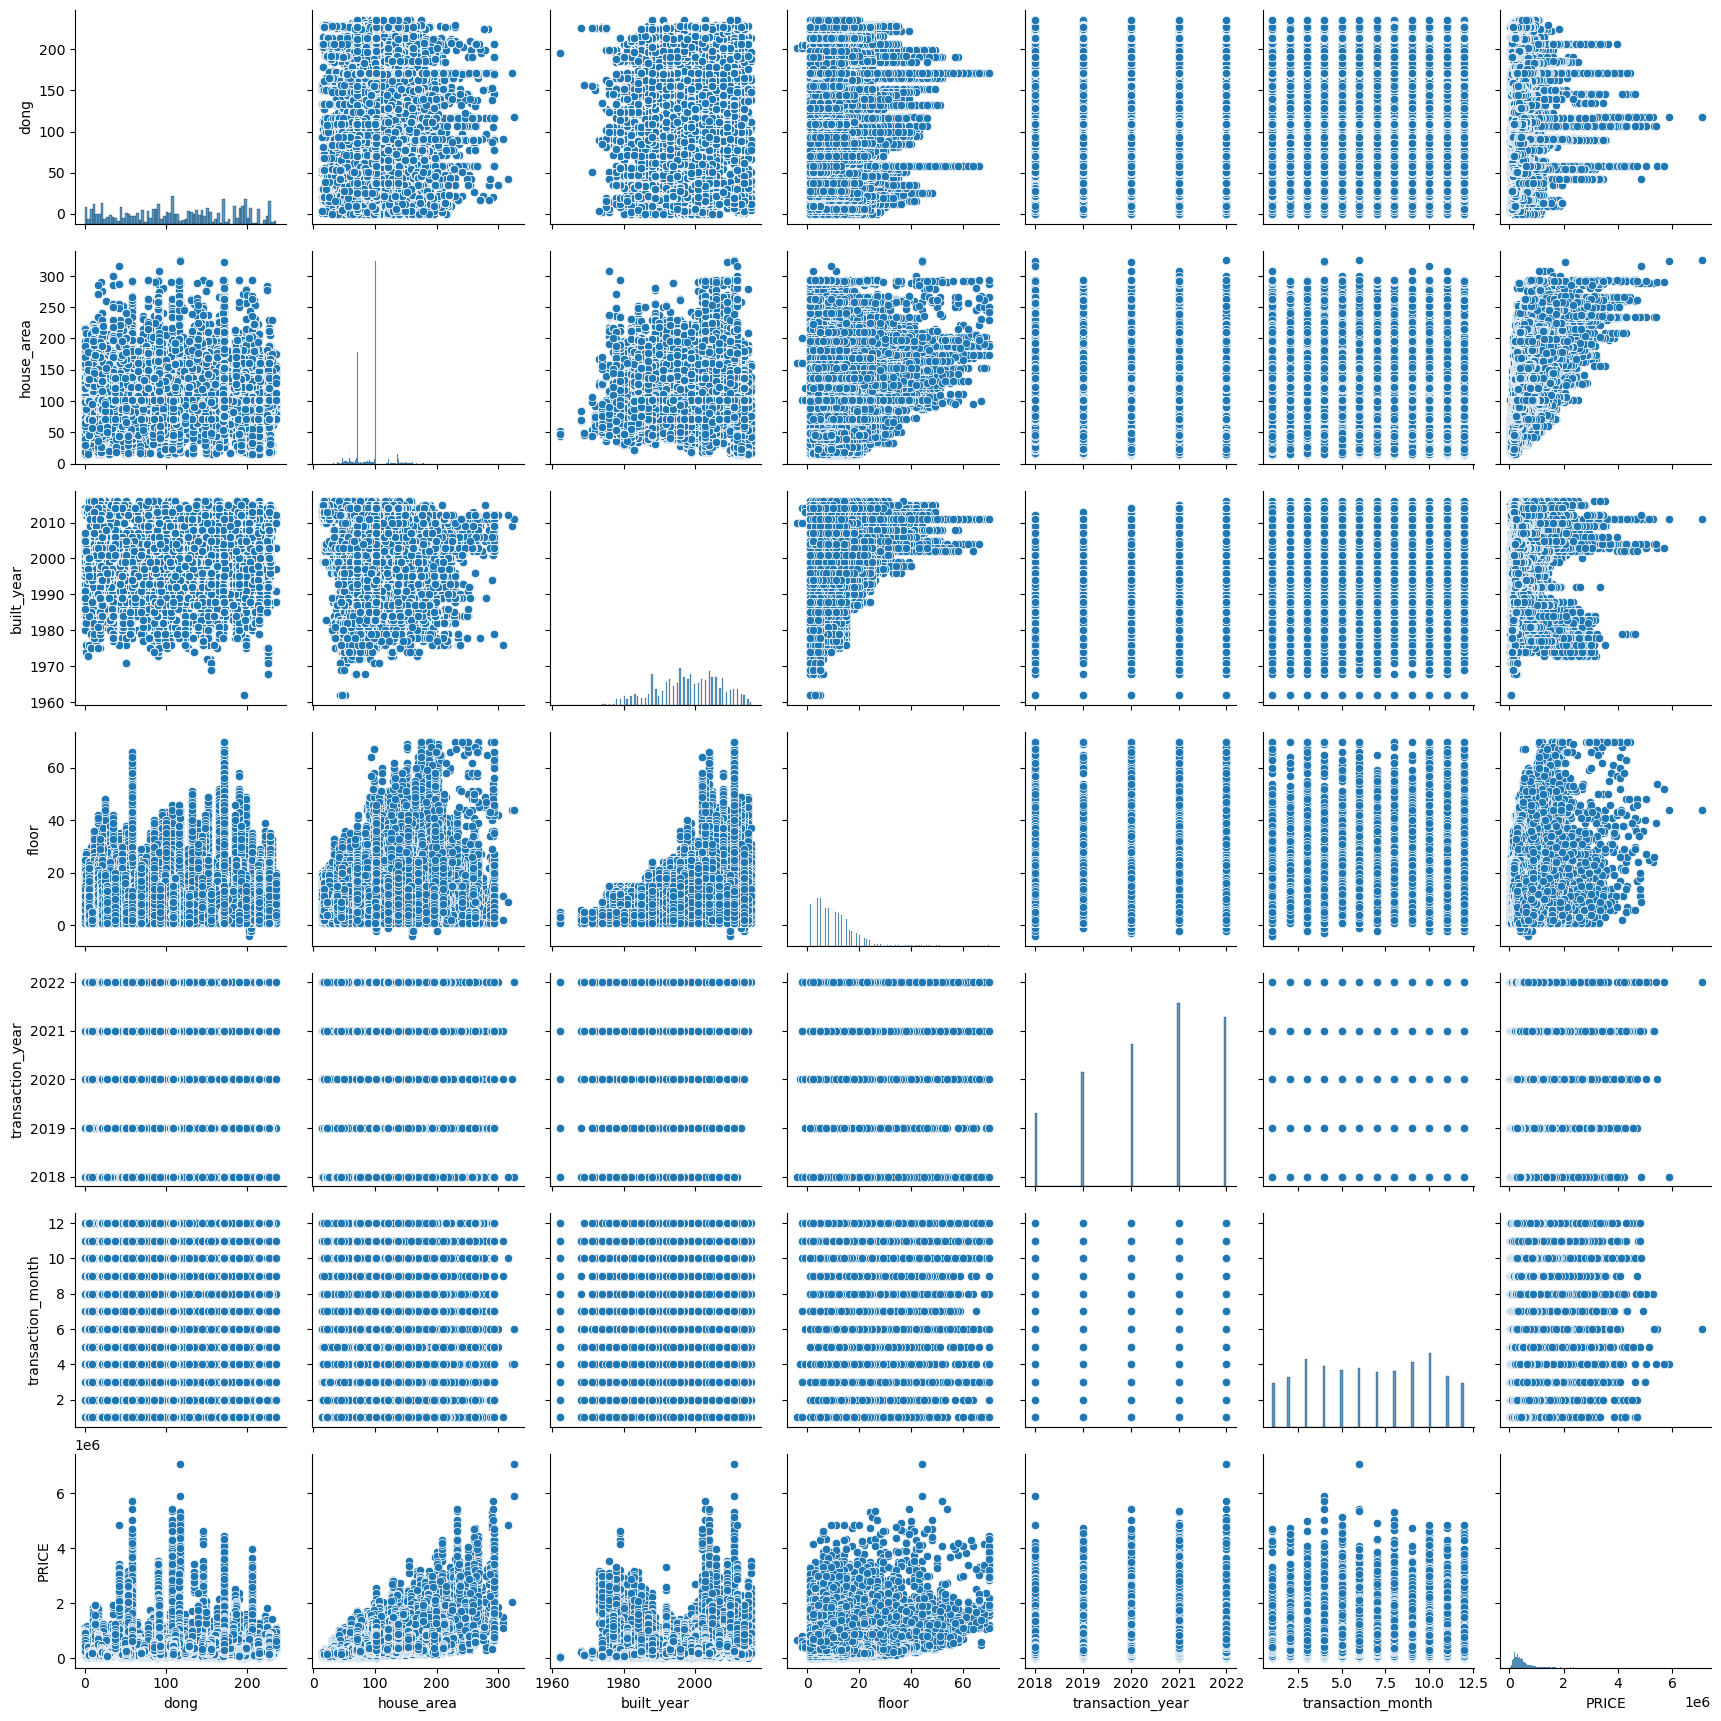

In [18]:
sns.pairplot(train[["dong", "house_area", "built_year", "floor", "transaction_year", "transaction_month", "transaction_day", "PRICE"]])

(array([2.0000e+00, 2.0000e+00, 7.0000e+00, 2.4000e+01, 2.2000e+01,
        8.0000e+00, 5.3000e+01, 2.3800e+02, 7.0900e+02, 2.5040e+03,
        6.7950e+03, 1.0285e+04, 1.5724e+04, 2.9045e+04, 3.4891e+04,
        4.4835e+04, 4.5721e+04, 4.3885e+04, 3.3470e+04, 2.5226e+04,
        1.5671e+04, 9.8100e+03, 5.5390e+03, 2.8410e+03, 1.3080e+03,
        6.6500e+02, 2.9200e+02, 8.6000e+01, 2.9000e+01, 3.0000e+00]),
 array([ 9.04796261,  9.272093  ,  9.4962234 ,  9.72035379,  9.94448419,
        10.16861458, 10.39274498, 10.61687537, 10.84100577, 11.06513616,
        11.28926656, 11.51339695, 11.73752734, 11.96165774, 12.18578813,
        12.40991853, 12.63404892, 12.85817932, 13.08230971, 13.30644011,
        13.5305705 , 13.7547009 , 13.97883129, 14.20296168, 14.42709208,
        14.65122247, 14.87535287, 15.09948326, 15.32361366, 15.54774405,
        15.77187445]),
 <BarContainer object of 30 artists>)

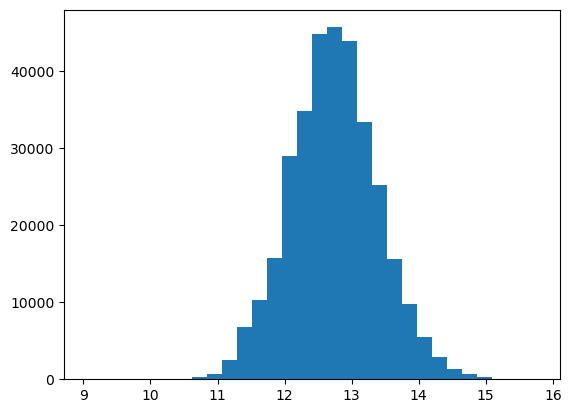

In [21]:
plt.hist(np.log(train["PRICE"]), bins=30)

(array([   89.,   169.,   576.,  1551.,   872.,  7357.,  2800.,  6938.,
        10011.,  5371., 14360.,  7918., 18937., 16823., 22931., 29032.,
        33341., 28319., 33545., 28663., 24037., 18083., 10282.,  4386.,
         1402.,   791.,   530.,   355.,   186.,    35.]),
 array([-5.67961599, -5.4805678 , -5.28151961, -5.08247142, -4.88342324,
        -4.68437505, -4.48532686, -4.28627867, -4.08723048, -3.8881823 ,
        -3.68913411, -3.49008592, -3.29103773, -3.09198954, -2.89294135,
        -2.69389317, -2.49484498, -2.29579679, -2.0967486 , -1.89770041,
        -1.69865223, -1.49960404, -1.30055585, -1.10150766, -0.90245947,
        -0.70341129, -0.5043631 , -0.30531491, -0.10626672,  0.09278147,
         0.29182966]),
 <BarContainer object of 30 artists>)

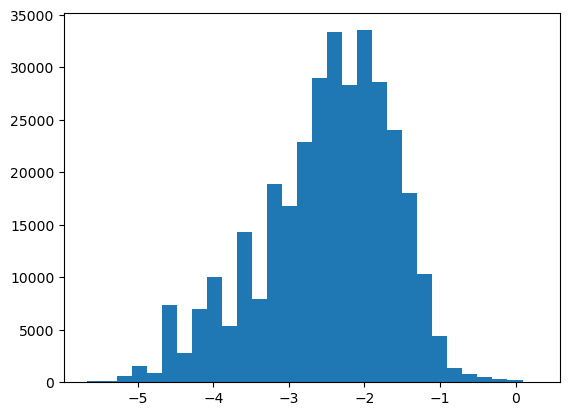

In [20]:
plt.hist(np.log(np.absolute(train["floor"])/train["house_area"]), bins=30)

(array([  137.,   128.,   323.,   586.,   905.,  1893.,  3162.,  7946.,
        12854., 19870., 20541., 28376., 20808., 28937., 18055., 18062.,
        18345., 19228., 22915.,     0., 23004.,     0., 22154.,     0.,
         4449., 16899.,     0.,     0.,     0., 20113.]),
 array([3.35789215, 3.49959143, 3.64129071, 3.78299   , 3.92468928,
        4.06638856, 4.20808784, 4.34978713, 4.49148641, 4.63318569,
        4.77488497, 4.91658426, 5.05828354, 5.19998282, 5.34168211,
        5.48338139, 5.62508067, 5.76677995, 5.90847924, 6.05017852,
        6.1918778 , 6.33357708, 6.47527637, 6.61697565, 6.75867493,
        6.90037422, 7.0420735 , 7.18377278, 7.32547206, 7.46717135,
        7.60887063]),
 <BarContainer object of 30 artists>)

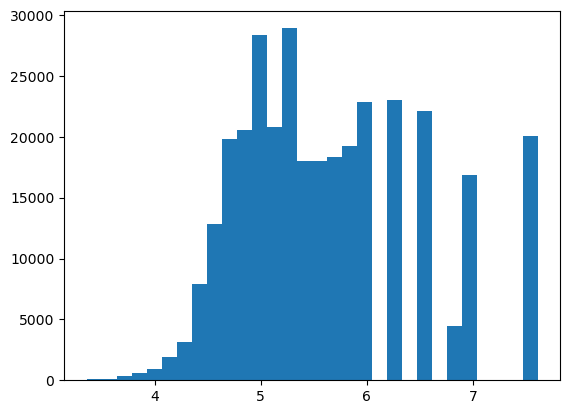

In [18]:
plt.hist(np.log(train["built_year"]/np.absolute(train["floor"])), bins=30)

In [19]:
combined_seoul["logfloor/area"] = np.log(np.absolute(combined_seoul["floor"])/combined_seoul["house_area"])
combined_seoul["logPrice"] = np.log(combined_seoul["PRICE"])
combined_seoul["logyear/floor"] = np.log(combined_seoul["built_year"]/np.absolute(combined_seoul["floor"]))

combined_seoul = combined_seoul.drop(["PRICE", "index", "apartment_id", "transaction_day"], axis=1)

In [20]:
combined_busan["logfloor/area"] = np.log(np.absolute(combined_busan["floor"])/combined_busan["house_area"])
combined_busan["logPrice"] = np.log(combined_busan["PRICE"])
combined_busan["logyear/floor"] = np.log(combined_busan["built_year"]/np.absolute(combined_busan["floor"]))

combined_busan = combined_busan.drop(["PRICE", "index", "apartment_id", "transaction_day"], axis=1)

*Add features to test dataset (same as train datasets)*

In [21]:
test_seoul = test[test["city"]=="seoul"]
test_busan = test[test["city"]=='busan']

In [22]:
park_stats = park_seoul.groupby(['dong', 'park_type']).agg({
    'park_type': 'count',
    'park_area': 'mean',
}).rename(columns={
    'park_type': 'park_count',
    'park_area': 'avg_area',
}).reset_index()

park_stats_pivot = park_stats.pivot(index='dong', columns='park_type')
park_stats_pivot.columns = ['{}_{}'.format(col[0], col[1]) for col in park_stats_pivot.columns]
df_combined = pd.merge(test_seoul, park_stats_pivot, left_on='dong', right_index=True, how='left')
df_combined.fillna(0, inplace=True)

temp_test_seoul = pd.merge(df_combined, park_seoul[["gu", "dong"]].drop_duplicates(), on='dong', how='left')

In [23]:
dcc_stats = dcc_seoul.groupby(['gu', 'day_care_type']).agg({
    'day_care_type': 'count',
    'day_care_baby_num': 'mean',
    'teacher_num': 'mean',
    'nursing_room_num': 'mean',
    'playground_num': 'mean',
    'CCTV_num': 'mean',
    'is_commuting_vehicle': 'mean',
    
}).rename(columns={
    'day_care_type': 'count',
    'day_care_baby_num': 'avg_babies',
    'teacher_num': 'avg_teachers',
    'nursing_room_num': 'avg_nursingrooms',
    'playground_num': 'avg_playgrounds',
    'CCTV_num': 'avg_cctv',
    'is_commuting_vehicle': 'avg_vehicles',
}).reset_index()

dcc_stats_pivot = dcc_stats.pivot(index='gu', columns='day_care_type')
dcc_stats_pivot.columns = ['{}_{}'.format(col[0], col[1]) for col in dcc_stats_pivot.columns]
combined_test_seoul = pd.merge(temp_test_seoul, dcc_stats_pivot, left_on='gu', right_index=True, how='left')

combined_test_seoul.fillna(0, inplace=True)

In [24]:
park_stats = park_busan.groupby(['dong', 'park_type']).agg({
    'park_type': 'count',
    'park_area': 'mean',
}).rename(columns={
    'park_type': 'park_count',
    'park_area': 'avg_area',
}).reset_index()

park_stats_pivot = park_stats.pivot(index='dong', columns='park_type')
park_stats_pivot.columns = ['{}_{}'.format(col[0], col[1]) for col in park_stats_pivot.columns]
df_combined = pd.merge(test_busan, park_stats_pivot, left_on='dong', right_index=True, how='left')
df_combined.fillna(0, inplace=True)

temp_test_busan = pd.merge(df_combined, park_busan[["gu", "dong"]].drop_duplicates(), on='dong', how='left')

In [25]:
dcc_stats = dcc_busan.groupby(['gu', 'day_care_type']).agg({
    'day_care_type': 'count',
    'day_care_baby_num': 'mean',
    'teacher_num': 'mean',
    'nursing_room_num': 'mean',
    'playground_num': 'mean',
    'CCTV_num': 'mean',
    'is_commuting_vehicle': 'mean',
    
}).rename(columns={
    'day_care_type': 'count',
    'day_care_baby_num': 'avg_babies',
    'teacher_num': 'avg_teachers',
    'nursing_room_num': 'avg_nursingrooms',
    'playground_num': 'avg_playgrounds',
    'CCTV_num': 'avg_cctv',
    'is_commuting_vehicle': 'avg_vehicles',
}).reset_index()

dcc_stats_pivot = dcc_stats.pivot(index='gu', columns='day_care_type')
dcc_stats_pivot.columns = ['{}_{}'.format(col[0], col[1]) for col in dcc_stats_pivot.columns]
combined_test_busan = pd.merge(temp_test_busan, dcc_stats_pivot, left_on='gu', right_index=True, how='left')
combined_test_busan.fillna(0, inplace=True)

In [26]:
combined_test_seoul["logfloor/area"] = np.log(np.absolute(combined_test_seoul["floor"])/combined_test_seoul["house_area"])
combined_test_seoul["logyear/floor"] = np.log(combined_test_seoul["built_year"]/np.absolute(combined_test_seoul["floor"]))

combined_test_busan["logfloor/area"] = np.log(np.absolute(combined_test_busan["floor"])/combined_test_busan["house_area"])
combined_test_busan["logyear/floor"] = np.log(combined_test_busan["built_year"]/np.absolute(combined_test_busan["floor"]))

In [28]:
combined_test_seoul = combined_test_seoul.drop_duplicates(subset='index')
combined_test_busan = combined_test_busan.drop_duplicates(subset='index')

Filling in missing values for lat and long

In [29]:
for i in set(combined_seoul.dong):
    combined_seoul[combined_seoul["dong"]==i].lat.fillna(float(combined_seoul[combined_seoul["dong"]==i].lat.mode()))
    combined_seoul[combined_seoul["dong"]==i].long.fillna(float(combined_seoul[combined_seoul["dong"]==i].long.mode()))

Some dongs in Busan don't have coordinate data at all, we will fill the null values by the mode of Busan's dong's coordinates

In [30]:
for i in set(combined_busan.dong):
    if len(combined_busan[combined_busan["dong"]==i].lat.mode()) > 0:
        combined_busan[combined_busan["dong"]==i].lat.fillna(float(combined_busan[combined_busan["dong"]==i].lat.mode()))
        combined_busan[combined_busan["dong"]==i].long.fillna(float(combined_busan[combined_busan["dong"]==i].long.mode()))
    else:
        combined_busan['lat'] = combined_busan['lat'].fillna(35.1479997081395)
        combined_busan['long'] = combined_busan['long'].fillna(128.9835518767628)

In [31]:
for i in set(combined_test_seoul.dong):
    combined_test_seoul[combined_test_seoul["dong"]==i].lat.fillna(float(combined_test_seoul[combined_test_seoul["dong"]==i].lat.mode()))
    combined_test_seoul[combined_test_seoul["dong"]==i].long.fillna(float(combined_test_seoul[combined_test_seoul["dong"]==i].long.mode()))

In [32]:
for i in set(combined_test_busan.dong):
    if len(combined_test_busan[combined_test_busan["dong"]==i].lat.mode()) > 0:
        combined_test_busan[combined_test_busan["dong"]==i].lat.fillna(float(combined_test_busan[combined_test_busan["dong"]==i].lat.mode()))
        combined_test_busan[combined_test_busan["dong"]==i].long.fillna(float(combined_test_busan[combined_test_busan["dong"]==i].long.mode()))
    else:
        combined_test_busan['lat'] = combined_test_busan['lat'].fillna(35.15053839047828)
        combined_test_busan['long'] = combined_test_busan['long'].fillna(128.99379738540426)

New feature generation based on latitude and longitude data

In [33]:
combined_seoul["x"] = np.cos(combined_seoul.lat*0.0174533) * np.cos(combined_seoul.long*0.0174533)
combined_seoul["y"] = np.cos(combined_seoul.lat*0.0174533) * np.sin(combined_seoul.long*0.0174533)
combined_seoul["z"] = np.sin(combined_seoul.long*0.0174533)

combined_busan["x"] = np.cos(combined_busan.lat*0.0174533) * np.cos(combined_busan.long*0.0174533)
combined_busan["y"] = np.cos(combined_busan.lat*0.0174533) * np.sin(combined_busan.long*0.0174533)
combined_busan["z"] = np.sin(combined_busan.long*0.0174533)

combined_test_seoul["x"] = np.cos(combined_test_seoul.lat*0.0174533) * np.cos(combined_test_seoul.long*0.0174533)
combined_test_seoul["y"] = np.cos(combined_test_seoul.lat*0.0174533) * np.sin(combined_test_seoul.long*0.0174533)
combined_test_seoul["z"] = np.sin(combined_test_seoul.long*0.0174533)

combined_test_busan["x"] = np.cos(combined_test_busan.lat*0.0174533) * np.cos(combined_test_busan.long*0.0174533)
combined_test_busan["y"] = np.cos(combined_test_busan.lat*0.0174533) * np.sin(combined_test_busan.long*0.0174533)
combined_test_busan["z"] = np.sin(combined_test_busan.long*0.0174533)

# 4. Modeling


For Seoul:

In [34]:
from sklearn.model_selection import train_test_split
X_train_seoul, X_validation_seoul, y_train_seoul, y_validation_seoul = train_test_split(combined_seoul, combined_seoul["logPrice"], train_size=0.8, random_state=42)

In [35]:
X_train_seoul.head()

,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,park_count_agricultural park,park_count_children park,...,avg_vehicles_etc,avg_vehicles_home,avg_vehicles_national/public,avg_vehicles_private,logfloor/area,logPrice,logyear/floor,x,y,z
168919,185,71.711560,2008,6,37.512281,127.085599,2021,5,0.0,0.0,...,0.043478,0.027778,0.000000,0.478261,-2.480892,13.611454,5.813135,-0.478320,0.632781,0.797735
135265,118,69.750137,1999,17,37.543500,127.037420,2020,10,0.0,0.0,...,0.400000,0.046154,0.052632,0.575758,-1.411706,12.793820,4.767189,-0.477588,0.632918,0.798242
6048,14,136.486379,1999,16,37.502385,126.862850,2021,1,0.0,4.0,...,0.076923,0.026316,0.015385,0.615385,-2.143636,12.976919,4.827814,-0.475919,0.634720,0.800073
180357,150,33.781934,2006,2,37.501184,127.038256,2019,10,0.0,7.0,...,0.000000,0.000000,0.000000,0.000000,-2.826779,12.683796,6.910751,-0.477868,0.633271,0.798233
162689,91,101.587391,2006,13,37.478794,126.992923,2021,1,0.0,15.0,...,0.136364,0.014286,0.028169,0.268293,-2.055970,13.375392,5.038949,-0.477510,0.633838,0.798709


Iterative hyperparameter range selection; final iteration shown below.

In [36]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def objective(trial):

    param = {
        'tree_method':'gpu_hist',
        'lambda': trial.suggest_float('lambda', 0.001, 1),
        'alpha': trial.suggest_float('alpha', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.1, 1),
        'n_estimators': trial.suggest_int('n_estimators', 1500, 3500),
        'max_depth': trial.suggest_int('max_depth', 6,10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    model = xg.XGBRegressor(**param)
    xgb_model = model.fit(X_train_seoul, y_train_seoul, eval_set=[(X_validation_seoul, y_validation_seoul)], early_stopping_rounds=25, verbose=0)
    rmse = RMSE(y_validation_seoul, xgb_model.predict(X_validation_seoul))
    return rmse
        
study_seoul_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_seoul_xgb.optimize(objective, n_trials=100)

[I 2023-06-05 00:37:13,333] A new study created in memory with name: no-name-78be698e-7f16-4b3d-8250-a92d7d5c748b
[I 2023-06-05 00:37:20,072] Trial 0 finished with value: 0.013695387302314743 and parameters: {'lambda': 0.7715493226234792, 'alpha': 0.030544429865807486, 'colsample_bytree': 0.8168241174631377, 'subsample': 0.8744019412693059, 'learning_rate': 0.5486563110723314, 'n_estimators': 1949, 'max_depth': 6, 'min_child_weight': 4}. Best is trial 0 with value: 0.013695387302314743.
[I 2023-06-05 00:37:34,811] Trial 1 finished with value: 0.010582076936791186 and parameters: {'lambda': 0.1699417257259729, 'alpha': 0.09745641603227016, 'colsample_bytree': 0.8426799091838986, 'subsample': 0.9766966730974682, 'learning_rate': 0.10355343969512301, 'n_estimators': 2524, 'max_depth': 10, 'min_child_weight': 4}. Best is trial 1 with value: 0.010582076936791186.
[I 2023-06-05 00:37:36,576] Trial 2 finished with value: 0.009634455434451366 and parameters: {'lambda': 0.7220335621143678, 'alp

In [39]:
study_seoul_xgb.best_trial

FrozenTrial(number=78, state=TrialState.COMPLETE, values=[0.009093325823252774], datetime_start=datetime.datetime(2023, 6, 5, 0, 41, 56, 553691), datetime_complete=datetime.datetime(2023, 6, 5, 0, 41, 58, 268878), params={'lambda': 0.5785325920543313, 'alpha': 0.5037734471170359, 'colsample_bytree': 0.9606212619520664, 'subsample': 0.8762869480492597, 'learning_rate': 0.6258660090758971, 'n_estimators': 2461, 'max_depth': 10, 'min_child_weight': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda': FloatDistribution(high=1.0, log=False, low=0.001, step=None), 'alpha': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'n_estimators': IntDistribution(high=3500, log=False, low=1500, step=1), 'max_depth': IntDistribution(h

In [40]:
study_seoul_xgb.best_trial.params

{'lambda': 0.5785325920543313,
 'alpha': 0.5037734471170359,
 'colsample_bytree': 0.9606212619520664,
 'subsample': 0.8762869480492597,
 'learning_rate': 0.6258660090758971,
 'n_estimators': 2461,
 'max_depth': 10,
 'min_child_weight': 1}

K-fold cross-validation to minimize data loss

In [41]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
test_pred_seoul = []
trial_seoul = study_seoul_xgb.best_trial
seoul_params = trial_seoul.params
kf = KFold(n_splits=5, shuffle=True, random_state=2023)
for i, (tr_index, val_index) in enumerate(kf.split(combined_seoul)):
    tr_x, tr_y = combined_seoul.drop(["logPrice"], axis=1).iloc[tr_index], combined_seoul.iloc[tr_index]["logPrice"]
    val_x, val_y = combined_seoul.drop(["logPrice"], axis=1).iloc[val_index], combined_seoul.iloc[val_index]["logPrice"]
    model_seoul = xg.XGBRegressor(**seoul_params, tree_method='gpu_hist')
    model_seoul.fit(tr_x, tr_y, eval_set=[(val_x, val_y)], early_stopping_rounds=25, verbose=0)
    test_pred_seoul.append(model_seoul.predict(combined_test_seoul.drop(['index', 'apartment_id', 'city', 'transaction_day'], axis=1)))

In [42]:
X_train_busan, X_validation_busan, y_train_busan, y_validation_busan = train_test_split(combined_busan.drop(["dong", "logPrice"], axis=1), combined_busan["logPrice"], train_size=0.8, random_state=42)

In [43]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def objective(trial):

    param = {
        'tree_method':'gpu_hist',
        'lambda': trial.suggest_float('lambda', 0.001, 1),
        'alpha': trial.suggest_float('alpha', 0.001, 2.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.001, 1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 3,15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    model = xg.XGBRegressor(**param)
    xgb_model = model.fit(X_train_busan, y_train_busan, eval_set=[(X_validation_busan, y_validation_busan)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(y_validation_busan, xgb_model.predict(X_validation_busan))
    return rmse
        
study_busan_rgb = optuna.create_study(direction='minimize', sampler=sampler)
study_busan_rgb.optimize(objective, n_trials=100)

[I 2023-06-05 00:47:02,079] A new study created in memory with name: no-name-578d028a-ef04-4572-b550-c89e78826a37
[I 2023-06-05 00:47:06,655] Trial 0 finished with value: 0.0903651606168042 and parameters: {'lambda': 0.7715493226234792, 'alpha': 0.042483146769443605, 'colsample_bytree': 0.6373117525770127, 'subsample': 0.7513158437132257, 'learning_rate': 0.49900850529028784, 'n_estimators': 1511, 'max_depth': 5, 'min_child_weight': 4}. Best is trial 0 with value: 0.0903651606168042.
[I 2023-06-05 00:48:29,894] Trial 1 finished with value: 0.08447378540794817 and parameters: {'lambda': 0.1699417257259729, 'alpha': 0.17759128853384654, 'colsample_bytree': 0.6885062201841192, 'subsample': 0.9538594127329871, 'learning_rate': 0.004944318061586537, 'n_estimators': 2805, 'max_depth': 13, 'min_child_weight': 4}. Best is trial 1 with value: 0.08447378540794817.
[I 2023-06-05 00:48:33,456] Trial 2 finished with value: 0.09002267618675863 and parameters: {'lambda': 0.7220335621143678, 'alpha': 

In [45]:
study_busan_rgb.best_trial

FrozenTrial(number=95, state=TrialState.COMPLETE, values=[0.08000490179541955], datetime_start=datetime.datetime(2023, 6, 5, 1, 9, 55, 186013), datetime_complete=datetime.datetime(2023, 6, 5, 1, 10, 27, 406119), params={'lambda': 0.23998903511909098, 'alpha': 0.19211406936723105, 'colsample_bytree': 0.9722554156250218, 'subsample': 0.8115764280385787, 'learning_rate': 0.022330645358758824, 'n_estimators': 4425, 'max_depth': 9, 'min_child_weight': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda': FloatDistribution(high=1.0, log=False, low=0.001, step=None), 'alpha': FloatDistribution(high=2.0, log=False, low=0.001, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.001, step=None), 'n_estimators': IntDistribution(high=5000, log=False, low=500, step=1), 'max_depth': IntDistribut

In [44]:
study_busan_rgb.best_trial.params

{'lambda': 0.23998903511909098,
 'alpha': 0.19211406936723105,
 'colsample_bytree': 0.9722554156250218,
 'subsample': 0.8115764280385787,
 'learning_rate': 0.022330645358758824,
 'n_estimators': 4425,
 'max_depth': 9,
 'min_child_weight': 1}

In [46]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
test_pred_busan = []
trial_busan = study_busan_rgb.best_trial
busan_params = trial_busan.params
kf = KFold(n_splits=5, shuffle=True, random_state=2023)
for i, (tr_index, val_index) in enumerate(kf.split(combined_busan)):
    tr_x, tr_y = combined_busan.drop(["logPrice"], axis=1).iloc[tr_index], combined_busan.iloc[tr_index]["logPrice"]
    val_x, val_y = combined_busan.drop(["logPrice"], axis=1).iloc[val_index], combined_busan.iloc[val_index]["logPrice"]
    model_busan = xg.XGBRegressor(**busan_params, tree_method='gpu_hist')
    model_busan.fit(tr_x, tr_y, eval_set=[(val_x, val_y)], early_stopping_rounds=25, verbose=0)
    test_pred_busan.append(model_busan.predict(combined_test_busan.drop(['index', 'apartment_id', 'city', 'transaction_day'], axis=1)))

# 5. Make submission

In [ ]:
pred_test_seoul = np.mean(test_pred_seoul, axis=0)
pred_test_busan = np.mean(test_pred_busan, axis=0)

In [48]:
combined_test_seoul["price"] = np.exp(pred_test_seoul)*1.12
combined_test_busan["price"] = np.exp(pred_test_busan)*1.11
res_test = pd.concat([combined_test_seoul, combined_test_busan])
res_test.sort_values(by=['index'])
pd.DataFrame({'index':res_test['index'].values, 'PRICE':res_test['price'].values}).to_csv('final.csv', index=False)